# Explore here

# ======================
# IMPORTAR LIBRERÍAS
# ======================
# CONFIGURACIÓN INICIAL
# ======================

In [15]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# Configurar rutas
BASE_PATH = "../"
RAW_PATH = os.path.join(BASE_PATH, "data/raw/train/")
INTERIM_PATH = os.path.join(BASE_PATH, "data/interim/full/")
MODEL_PATH = os.path.join(BASE_PATH, "models/")
REPORT_PATH = os.path.join(BASE_PATH, "reports/")

# Crear directorios necesarios
os.makedirs(INTERIM_PATH, exist_ok=True)
os.makedirs(os.path.join(INTERIM_PATH, "cats"), exist_ok=True)
os.makedirs(os.path.join(INTERIM_PATH, "dogs"), exist_ok=True)
os.makedirs(os.path.join(INTERIM_PATH, "train/cats"), exist_ok=True)
os.makedirs(os.path.join(INTERIM_PATH, "train/dogs"), exist_ok=True)
os.makedirs(os.path.join(INTERIM_PATH, "validation/cats"), exist_ok=True)
os.makedirs(os.path.join(INTERIM_PATH, "validation/dogs"), exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(REPORT_PATH, exist_ok=True)

# ======================
# FUNCIONES AUXILIARES
# ======================
def process_images(source_path, dest_path, target_size=(200, 200)):
    """Redimensiona imágenes y las organiza en carpetas por clase"""
    # Crear directorios necesarios
    os.makedirs(os.path.join(dest_path, "cats"), exist_ok=True)
    os.makedirs(os.path.join(dest_path, "dogs"), exist_ok=True)
    
    for filename in os.listdir(source_path):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            img = cv2.imread(os.path.join(source_path, filename))
            if img is not None:
                img = cv2.resize(img, target_size)
                
                
                if filename.lower().startswith('cat'):
                    class_folder = 'cats'
                elif filename.lower().startswith('dog'):
                    class_folder = 'dogs'
                else:
                    print(f"Archivo no clasificado: {filename}")
                    continue
                    
                dest_file = os.path.join(dest_path, class_folder, filename)
                cv2.imwrite(dest_file, img)

def split_dataset(base_path):
    """Divide el dataset en entrenamiento y validación"""
    for animal in ['cats', 'dogs']:
        animal_path = os.path.join(base_path, animal)
        if not os.path.exists(animal_path):
            os.makedirs(animal_path, exist_ok=True)
        files = [f for f in os.listdir(animal_path) if f.endswith('.jpg')]
        train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)
        
        # Mover a entrenamiento
        for file in train_files:
            src = os.path.join(animal_path, file)
            dst = os.path.join(base_path, 'train', animal, file)
            shutil.copy(src, dst)
        
        # Mover a validación
        for file in val_files:
            src = os.path.join(animal_path, file)
            dst = os.path.join(base_path, 'validation', animal, file)
            shutil.copy(src, dst)

def plot_class_distribution(train_path, val_path):
    """Muestra la distribución de clases"""
    train_cats = len(os.listdir(os.path.join(train_path, "cats")))
    train_dogs = len(os.listdir(os.path.join(train_path, "dogs")))
    val_cats = len(os.listdir(os.path.join(val_path, "cats")))
    val_dogs = len(os.listdir(os.path.join(val_path, "dogs")))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=['Gatos (Train)', 'Perros (Train)', 'Gatos (Val)', 'Perros (Val)'],
        y=[train_cats, train_dogs, val_cats, val_dogs]
    )
    plt.title("Distribución de Clases")
    plt.ylabel("Cantidad")
    plt.savefig(os.path.join(REPORT_PATH, "class_distribution.png"))
    plt.show()

def plot_image_samples(path, title, num_samples=5):
    """Muestra muestras de imágenes"""
    files = [f for f in os.listdir(path) if f.endswith('.jpg')][:num_samples]
    
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)
    
    for i, filename in enumerate(files):
        img = plt.imread(os.path.join(path, filename))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(REPORT_PATH, f"{title.lower().replace(' ', '_')}_samples.png"))
    plt.show()

In [16]:
print(f"Gatos procesados: {len(os.listdir(os.path.join(INTERIM_PATH, 'cats')))}")
print(f"Perros procesados: {len(os.listdir(os.path.join(INTERIM_PATH, 'dogs')))}")

Gatos procesados: 12500
Perros procesados: 12500


# ======================
# PREPARACIÓN DE DATOS
# ======================

Ruta origen: ../data/raw/train/
Existe: True
Archivos: 25000
Gatos procesados: 12500
Perros procesados: 12500
Dividiendo dataset...
Visualizando distribución de clases...


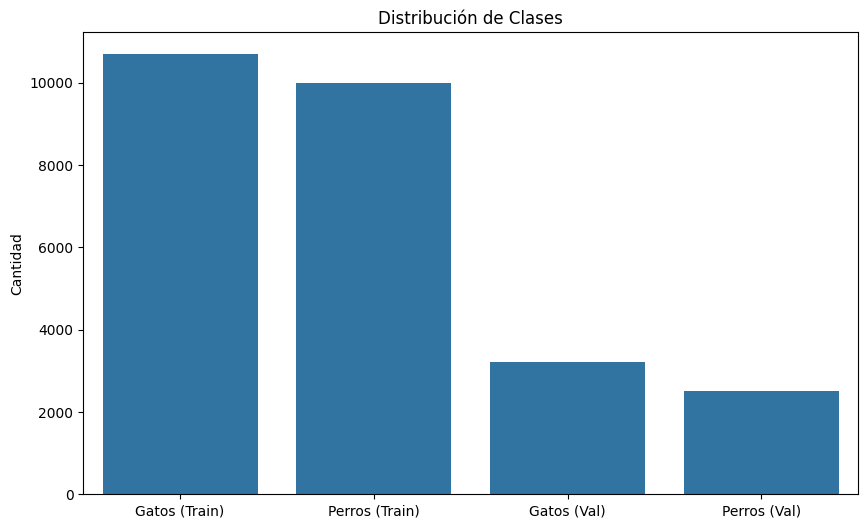

Visualizando muestras de gatos...


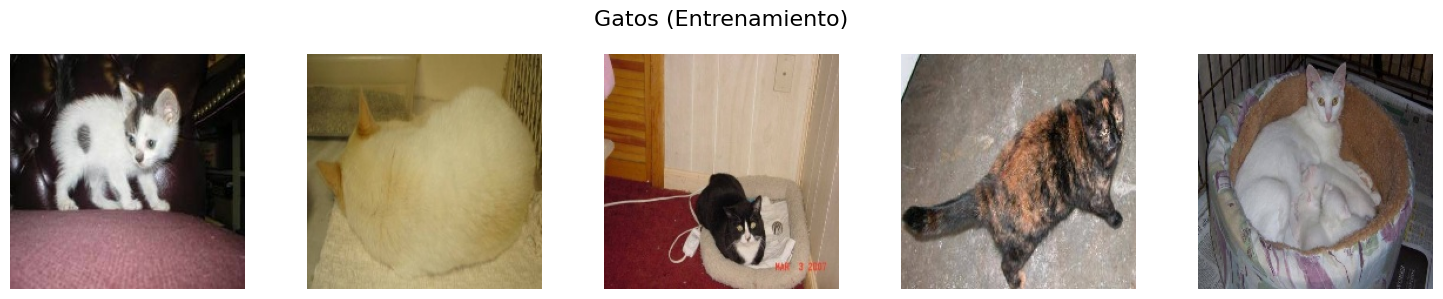

Visualizando muestras de perros...


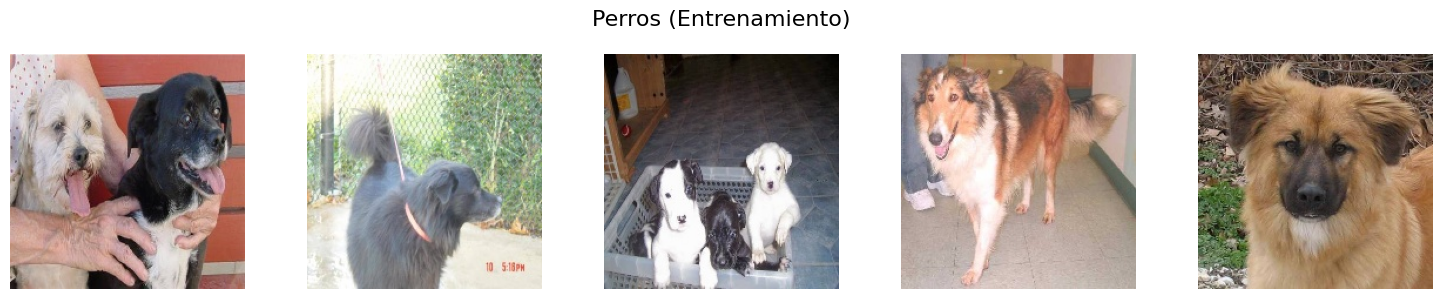

In [17]:
print(f"Ruta origen: {RAW_PATH}")
print(f"Existe: {os.path.exists(RAW_PATH)}")
print(f"Archivos: {len(os.listdir(RAW_PATH))}")

process_images(RAW_PATH, INTERIM_PATH, target_size=(200, 200))

print(f"Gatos procesados: {len(os.listdir(os.path.join(INTERIM_PATH, 'cats')))}")
print(f"Perros procesados: {len(os.listdir(os.path.join(INTERIM_PATH, 'dogs')))}")

print("Dividiendo dataset...")
split_dataset(INTERIM_PATH)

# Visualizar distribución de clases
print("Visualizando distribución de clases...")
plot_class_distribution(
    train_path=os.path.join(INTERIM_PATH, "train"),
    val_path=os.path.join(INTERIM_PATH, "validation")
)

# Visualizar muestras
print("Visualizando muestras de gatos...")
plot_image_samples(
    path=os.path.join(INTERIM_PATH, "train/cats"),
    title="Gatos (Entrenamiento)"
)

print("Visualizando muestras de perros...")
plot_image_samples(
    path=os.path.join(INTERIM_PATH, "train/dogs"),
    title="Perros (Entrenamiento)"
)

# ======================
# GENERADORES DE DATOS
# ======================

In [18]:
# Aumento de datos para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Solo reescalar para validación
val_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_generator = train_datagen.flow_from_directory(
    os.path.join(INTERIM_PATH, "train"),
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(INTERIM_PATH, "validation"),
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)

Found 20696 images belonging to 2 classes.
Found 5710 images belonging to 2 classes.


# ======================
# CONSTRUCCIÓN DEL MODELO
# ======================

In [19]:
# Versión simplificada de VGG para estudiantes
model = Sequential([
    # Bloque 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    # Bloque 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    # Bloque 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    # Clasificador
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


2025-07-16 19:29:56.166659: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 163840000 exceeds 10% of free system memory.
2025-07-16 19:29:56.432230: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 163840000 exceeds 10% of free system memory.


Model: "sequential_1"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)     

# ======================
# ENTRENAMIENTO
# ======================

In [21]:
# Callbacks
checkpoint = ModelCheckpoint(
    os.path.join(MODEL_PATH, 'best_model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stop]
)

# Guardar modelo final
model.save(os.path.join(MODEL_PATH, 'final_model.h5'))


SyntaxError: keyword argument repeated: validation_steps (2127557509.py, line 24)

# ======================
# EVALUACIÓN Y RESULTADOS
# ======================

NameError: name 'history' is not defined

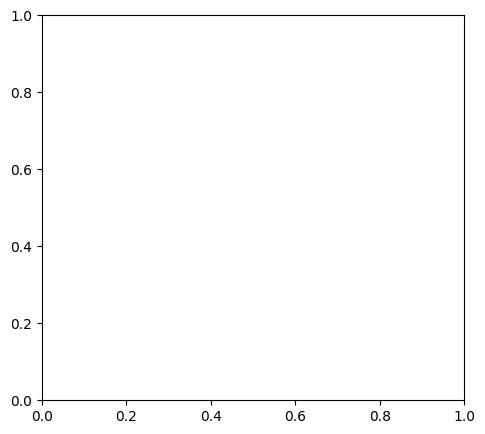

In [22]:
# Gráficas de entrenamiento
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(REPORT_PATH, 'training_history.png'))
plt.show()

# Evaluación final
test_loss, test_acc = model.evaluate(validation_generator)
print(f'\nPrecisión final en validación: {test_acc:.4f}')
print(f'Pérdida final en validación: {test_loss:.4f}')

# Matriz de confusión
y_true = []
y_pred = []

# Predecir todo el conjunto de validación
for i in range(len(validation_generator)):
    X, y = validation_generator[i]
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(model.predict(X), axis=1))

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=['Gatos', 'Perros']))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Gatos', 'Perros'], 
            yticklabels=['Gatos', 'Perros'])
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.savefig(os.path.join(REPORT_PATH, 'confusion_matrix.png'))
plt.show()
